# Squares (single regular polygon)

We define some scripts to create the cutting patterns for one of the 3 regular tesselations.<br>
In particular for the square.

### Strategy

- We define a basic shape made of a triangle using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [28]:
# Imports
import math

from shapely.geometry import Polygon, box
from shapely import affinity, centroid, polygons

import svgwrite
from svgwrite import mm

import matplotlib.pyplot as plt
import numpy as np

In [29]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg,
    crop_and_save_tile,
)

## FUNCTION DEFINITIONS

### Canvas and Polygon sizes

In [30]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 170
tabica_width = 908

INSET_DISTANCE = 3.3   # X ratio gives gaps of about 2Xmm solid channels

polygon_radius = 24 #24 

### Polygon creation

In [31]:
# Create a square (4 sides)
square = create_regular_polygon(0,0, polygon_radius, 4)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [32]:
rotated_polygon = affinity.rotate(square, 90, origin="centroid")

polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
polygon_dict['T1'] = affinity.translate(rotated_polygon, 
                                        polygon_radius,
                                        polygon_radius,
                                        )
 
polygon_dict['T2'] = affinity.translate(rotated_polygon, 
                                 +2*polygon_radius,
                                 +0) 

polygon_dict['T3'] = affinity.translate(rotated_polygon,
                                +3*polygon_radius*math.cos(math.pi/6), 
                                1*polygon_radius*(1+ math.sin(math.pi/6)),
)

polygon_dict['T4'] = affinity.translate(rotated_polygon, 
                                        +2*polygon_radius*math.cos(math.pi/6),
                                       +2*polygon_radius*(1+ math.sin(math.pi/6)))


polygon_dict['T5'] = affinity.translate(rotated_polygon, 
                                        +3*polygon_radius*math.cos(math.pi/6),
                                       +3*polygon_radius*(1+ math.sin(math.pi/6)))

polygon_dict['T6'] = affinity.translate(rotated_polygon, 
                                        +3*polygon_radius*math.cos(math.pi/6),
                                       +5*polygon_radius*(1+ math.sin(math.pi/6)))        

### Plotting Dictionaries of Shapes

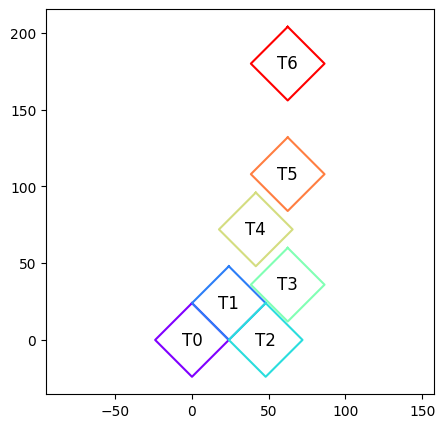

In [33]:
plot_polygon_dict(polygon_dict)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [34]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define 2 translations
- **up_t:** For *up* triangles
- **down_t:** For *down* triangles 


In [35]:
def translate_polygon(initial_polygon_list, x, y):
    translated_polygon = affinity.translate(initial_polygon_list, 
                                            + x * polygon_radius,
                                            + y * polygon_radius)
    return translated_polygon

### Plotting Lists of Polygons

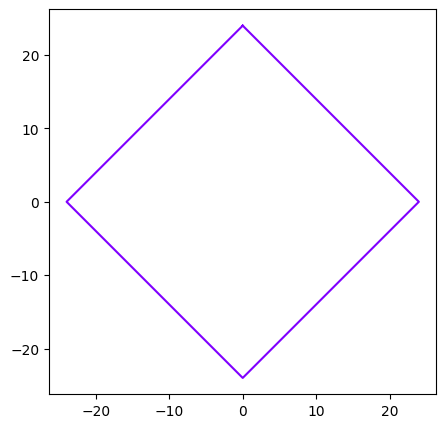

In [36]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

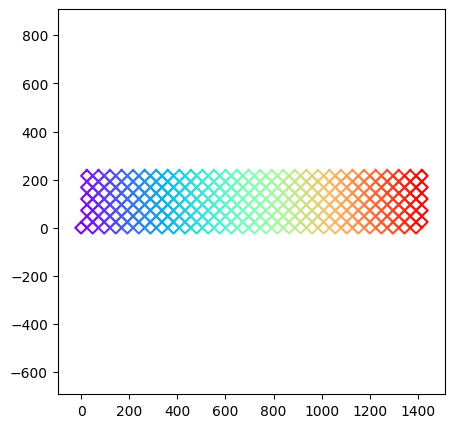

In [37]:
polygon_dict = {}
polygon_dict['T0'] = rotated_polygon
initial_polygon_list = list(polygon_dict.values())
full_polygon_list = [rotated_polygon]
first_row = []



for x in range(1,60):
    # create the first column
    first_column = []
    for y in range(0,5):
        new_polygon = affinity.translate(rotated_polygon, 
                                        +0*2*x*polygon_radius,
                                        +2*y*polygon_radius)
        first_column.append(new_polygon)

    # create the second column
    if x % 2 != 0:
        new_column = [affinity.translate(poly, x*polygon_radius, polygon_radius) for poly in first_column]
    else:
        new_column = [affinity.translate(poly, x*polygon_radius, 0) for poly in first_column]
    
    full_polygon_list.extend(new_column)

plot_polygon_list(full_polygon_list)


# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [38]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [39]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

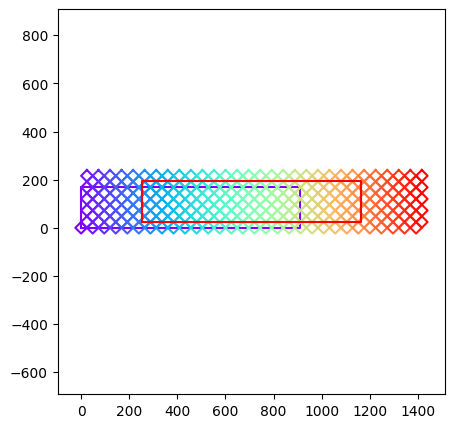

In [40]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

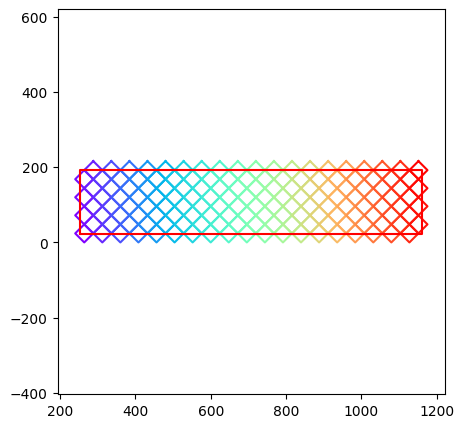

In [41]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [42]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))



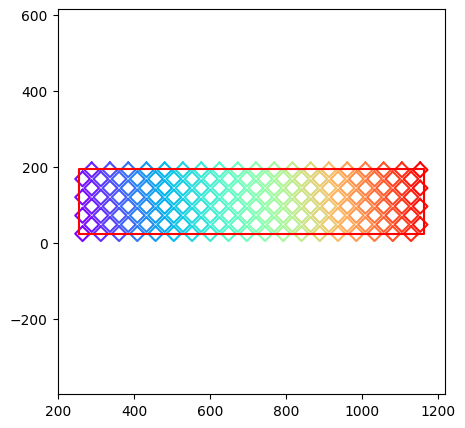

In [43]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Crop polygons outside of inner tile

In [44]:
# Create inner tile
# Inner tile is:
# - 22 cm inside the frame (left and right)
# - 26 cm higher than the bottom border of the frame
# - centered horizontally

# Get frame bounds for calculations
xmin, ymin, xmax, ymax = centered_frame.bounds

# Inner tile margins (in centimeters)
left_inset = 12
right_inset = 12
bottom_inset = 26

# Calculate new xmin and xmax (sides inset by 22 cm)
inner_xmin = xmin + left_inset
inner_xmax = xmax - right_inset

# Calculate new ymin (bottom inset by 26 cm)
inner_ymin = ymin + bottom_inset

# The top of the inner tile is flush with the top of the frame
inner_ymax = inner_ymin + 120

# Create the inner tile polygon
from shapely.geometry import Polygon

inner_tile = Polygon([
    (inner_xmin, inner_ymin),
    (inner_xmin, inner_ymax),
    (inner_xmax, inner_ymax),
    (inner_xmax, inner_ymin)
])

152


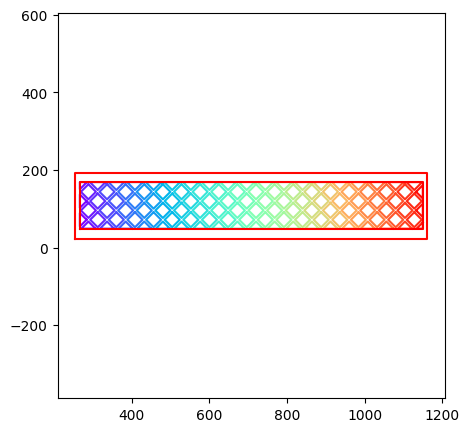

In [45]:
poly_crop = crop_and_save_tile(inset_polygon_list, inner_tile, save_holes=False)
plot_polygon_list(poly_crop + [centered_frame, inner_tile])

In [46]:
final_polygons =  poly_crop + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [47]:
len(final_polygons)

115

In [48]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 8:
        final_polygons.remove(poly)
    

In [49]:
len(final_polygons)

115

### Save POLYGONS to SVG

# SAVE


In [50]:
save_polygon_list_to_svg(final_polygons, filename='tramo1.4.svg')

In [51]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in final_polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tramo1.4.png', dpi=300, bbox_inches='tight')
plt.close()


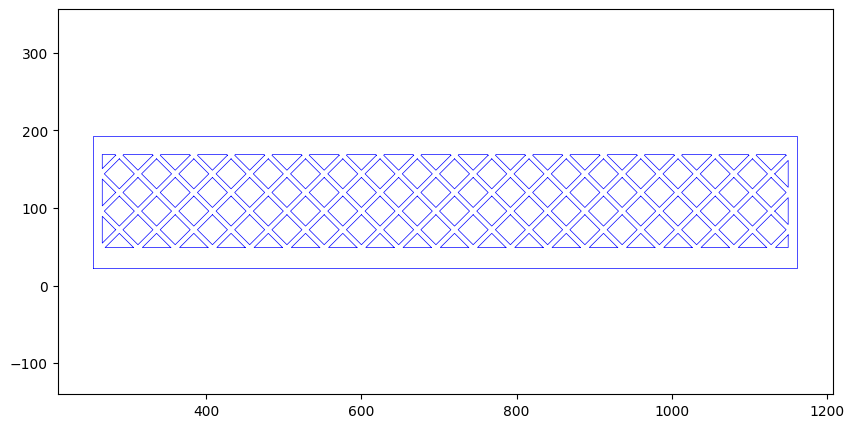

In [52]:
blue_plot(final_polygons)

In [53]:
import numpy as np
from polygon_duplicates import find_duplicate_polygons

# Your polygons as numpy arrays
polygons = [
    np.array([[0, 0], [1, 0], [1, 1], [0, 1]]),
    np.array([[1, 0], [1, 1], [0, 1], [0, 0]]),  # Same as first polygon but rotated
    np.array([[2, 2], [3, 2], [3, 3], [2, 3]])   # Different polygon
]

duplicates = find_duplicate_polygons(full_polygon_list)

In [54]:
duplicates

[]